In [1]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

import arviz as az

In [2]:
az.style.use('arviz-white')

# Gibbs sampling for the concussions data

Let $Y_i$ be the number of concussions (aggregated over all teams and games) in season $i$ (1=2012,…,4=2015). We model these counts as $Y_i\sim\mbox{Poisson}(N\lambda_i) \mbox{  where  } \lambda_i \mid \gamma\sim\mbox{Gamma}(1,\gamma),$ $\lambda_i$ is the concussion rate in year $i$ and $N$ is the number of games in each year. The prior for $\gamma$ is $\gamma\sim\mbox{Gamma}(a,b)$. The objective is to deterimine if the concussion rate has changed over time by comparing the posteriors of the $\lambda_i$.

Gibbs sampling cycles through the parameters and updates each using a draw from its full conditional distributions. The full conditional distributions are:

$$\lambda_i \mid \mbox{rest}\sim\mbox{Gamma}(Y_i+1,N+\gamma)$$

and

$$\gamma \mid \mbox{rest}\sim\mbox{Gamma}(a+4,b+\sum_{i=1}^4\lambda_i).$$

This produces draws from the joint posterior of $(\lambda_1, \dots,\lambda_4,\gamma)$

To evaluate whether the rate has changed between years $i$ and $j$, we approximate the posterior probabilities that $\lambda_i > \lambda_j$ using the proportion of the MCMC samples for which this is the case.

## Load the data

In [3]:
Y = np.array([171, 152, 123, 199])
n = 4
N = 256

## Gibbs sampling

In [4]:
# Create an empty matrix for the S MCMC samples
S = 2500
samples = np.zeros((S, 5))
#colnames(samples) = c("lam1", "lam2", "lam3", "lam4", "gamma")

# Initial values
λ = np.log(Y/N)
γ = 1/λ.mean()

# priors: lambda|gamma ~ Gamma(1,gamma), gamma ~ InvG(a,b)
a = 0.1
b = 0.1

# Gibbs sampling
for s in range(S):
    λ = stats.gamma(Y+1, scale=1/(N+γ)).rvs()
    gamma = stats.gamma(a + 4, scale=1/(b + λ.sum())).rvs(1)[0]
    samples[s,] = *λ, gamma

## Summarize the posterior

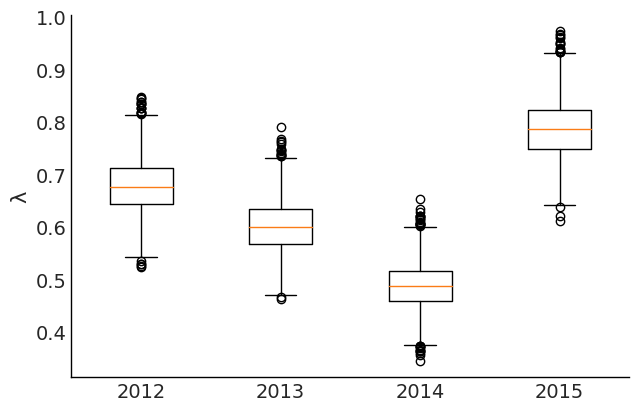

In [5]:
plt.boxplot(samples[:,:4], labels=[y for y in range(2012, 2016)])
plt.ylabel('λ');

In [6]:
trace = {k:v for k, v in zip(("λ1","λ2","λ3","λ4","γ"), samples.T)}

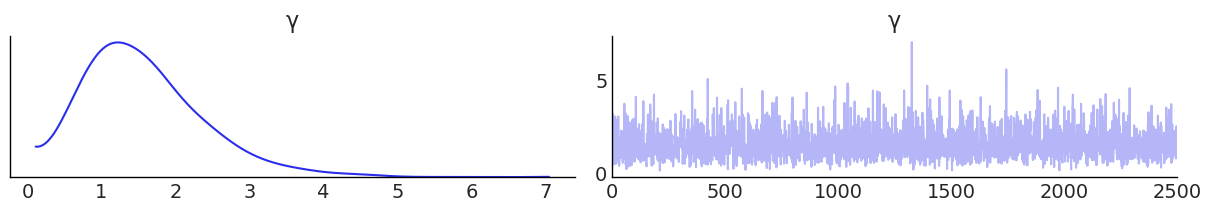

In [7]:
az.plot_trace(trace, var_names=['γ']);

In [8]:
az.summary(trace)

,mean,sd,mc error,hpd 3%,hpd 97%
λ1,0.68,0.05,0.00,0.58,0.77
λ2,0.60,0.05,0.00,0.51,0.69
λ3,0.49,0.04,0.00,0.41,0.57
λ4,0.79,0.05,0.00,0.69,0.89
γ,1.58,0.80,0.01,0.34,3.09


## Approximate $\text{Prob}(\lambda_i > \lambda_j \mid Y)$ for all pairs of $i$ and $j$

In [9]:
# Is the rate higher in 2015 than 2012?
np.mean(samples[:, 3] > samples[:, 0])

0.9244

In [10]:
# Is the rate higher in 2014 than 2012?
np.mean(samples[:, 2] > samples[:, 0])

0.0028

In [11]:
# Is the rate higher in 2013 than 2012?
np.mean(samples[:, 1] > samples[:, 0])

0.1376

In [12]:
# Is the rate higher in 2015 than 2013?
np.mean(samples[:, 4] > samples[:, 1])

0.93

In [13]:
# Is the rate higher in 2014 than 2013?
np.mean(samples[:, 2] > samples[:, 1])

0.0444

In [14]:
# Is the rate higher in 2015 than 2014?
np.mean(samples[:, 3] > samples[:, 2])

1.0